In [ ]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage
from dotenv import load_dotenv
from typing import Literal,TypedDict,List,Annotated
from pydantic import BaseModel,Field

: 

In [2]:
load_dotenv() ## activating up all the secret variables in my local system

True

In [3]:
llm = ChatOpenAI()

In [4]:
llm.invoke("what is Data Science").content ## the llm is working fine

'Data science is a multi-disciplinary field that uses scientific methods, processes, algorithms, and systems to extract knowledge and insights from structured and unstructured data. It combines techniques from statistics, machine learning, data mining, and other related fields to analyze large volumes of data and make predictions or guide decision-making. Data science plays a crucial role in various industries, including finance, healthcare, e-commerce, and marketing, by helping organizations better understand their data and derive actionable insights.'

In [5]:
## creating the structured llm which will directly give the feedback and response(good or bad) in pydantic format
## not in basic content format
class Schema(BaseModel):
    response:Literal["good","bad"] = Field(description = "The nature of the tweet either good or bad")
    feedback:str = Field(description = "The feedback based on the generated tweet.")

In [6]:
structured_llm = llm.with_structured_output(Schema)

d:\Langgraph_revision\venv\lib\site-packages\langchain_openai\chat_models\base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [7]:
## creating the State Class which will flow through the entire workflow
## each component will have access to this state where each component or node can add ,extract or modify the data accordingly
import operator
class State(TypedDict):
    topic:str
    tweet:str
    response:str
    feedback:str
    iterations:int
    max_iterations:int
    tweet_history:Annotated[List,operator.add]
    feedback_history:Annotated[List,operator.add]

In [8]:
## now lets creating the all the nodes
## first is tweet generator which will generate the code
def tweet_generator(state:State)->dict:
    ## fetching the topic which user has provided 
    topic = state["topic"]

    messages = [
SystemMessage(content = "You are a tweet generator.Note that tweet generated by you must be funny and should" \
"not include question answer ,The tweet should not be very long and very short.The tweet should be such that it should be funny" \
"but should not affect any one's sentiment.The wording of the tweet should be clear."),
HumanMessage(content = "generate a tweet based on the topic {topic}")
]
    
    tweet = llm.invoke(messages).content
    return {"tweet":tweet,"tweet_history":[tweet]}

In [ ]:
## till here i have created the tweet ,now we need to check either this tweet is good or not
## by using evaluator agent

def evaluate_tweet(state:State) ->dict:
    ## fetch the tweet and topic from state
    topic = state["topic"]
    tweet = state["tweet"]

    messages = [SystemMessage(content = "You are an intelligent system which evaluates the tweet.You are not baised to " \
    "any one.You must check either the tweet is correct in grammer,it does not hurt the sentiments of any one,there is " \
    "some humour invloved in the tweet,the tweet is not too long or not too short,if tweet is good and following these crieterias" \
    "then return response as 'good' or 'bad'. Also give the feedback if the response is bad so that we can generate new tweet based" \
    "on this feedback."),
    HumanMessage(content = "This is the topic of tweet:{topic} and here is the tweet:\n {tweet}" \
    "analyze the tweet and return the response and feedback.")]
    result = structured_llm.invoke(messages)
    response = result.response
    feedback = result.feedback
    print("feedback:\n",feedback)
    return {"response":response,"feedback":feedback,"feedback_history":[feedback]}

In [10]:
## now suppose at this point of time we have evaluated the tweet
## now there are two cases possible 
## first possible case is the tweet is good then we will end the garph and will provide the tweet to the user
## and in second case we will send the tweet along with feedback to optimizer
## this optimizer using using the feedback will regenerate the response
## as this response is generated we will increase the iteration by 1
## before coming to optimizer we will check in router function 
## either the number of iterations are excedding the maximum iterations or not
## of yes then we will give message our system is not able to genearte good tweet as of now
## please try again later

In [11]:
## before creating the optimizer cretae the router
def router(state:State) ->str:
    response = state["response"]
    iterations = state["iterations"]
    max_iterations = state["max_iterations"]
    if iterations == max_iterations:
        return "got_nothing"
    if (response == "good"):
       return END
    elif response == "bad":
        return "optimizer"

In [12]:
def got_nothing(state:State) ->dict:
    tweet = "I am not able to generate good tweet as of now.Please try after some time."
    
    return {"tweet":tweet}

In [31]:
def optimizer(state:State)->dict:
    feedback = state["feedback"]
    tweet = state["tweet"]
    iterations = state["iterations"] + 1
    print("tweet:\n",tweet)
    print("feedback:\n",feedback)

    messages = [SystemMessage(content = "You are a tweet optimizer.You will be provided a tweet which will not be well written." \
    "Your job is to correct the tweet based on the provided feedback and regenerate the tweet"),
    HumanMessage(content = "This is the tweet:\n {tweet} and its feedback:\n {feedback}")
    ]
    tweet = llm.invoke(messages).content
    return {"tweet":tweet,"iterations":iterations,"tweet_history":[tweet]}    

In [14]:
## till here i have created all the components or nodes
## now i need to join all the components or nodes in the graph

In [36]:
graph = StateGraph(State)
graph.add_node("tweet_generator",tweet_generator)
graph.add_node("evaluate_tweet",evaluate_tweet)
graph.add_node("got_nothing",got_nothing)
graph.add_node("optimizer",optimizer)

## defined all the nodes of the graph
## now joing all the nodes in the graph
graph.add_edge(START,"tweet_generator")
graph.add_edge("tweet_generator","evaluate_tweet")
graph.add_conditional_edges("evaluate_tweet",router,{"got_nothing":"got_nothing",END:END,"optimizer":"optimizer"})
graph.add_edge("got_nothing",END)
graph.add_edge("optimizer","evaluate_tweet")

workflow = graph.compile()



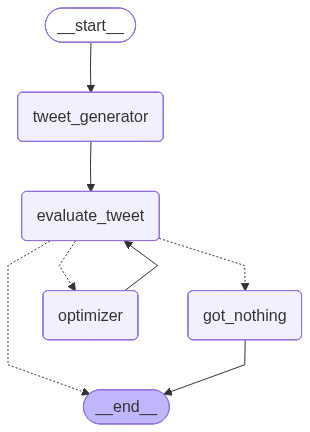

In [33]:
workflow

In [37]:
initial_state = {"topic":"AI in India","iterations":0,"max_iterations":5}
final_state = workflow.invoke(initial_state)
print(final_state)

feedback:
 The input is incomplete. Please provide the topic and tweet for analysis.
tweet:
 "Why did the scarecrow win an award? Because he was outstanding in his field! 🌾🏆 #DadJokes"
feedback:
 The input is incomplete. Please provide the topic and tweet for analysis.
feedback:
 
{'topic': 'AI in India', 'tweet': "I'm sorry, I cannot see the tweet or feedback provided. Please provide me with the tweet and the feedback so I can help optimize it for you.", 'response': 'good', 'feedback': '', 'iterations': 1, 'max_iterations': 5, 'tweet_history': ['"Why did the scarecrow win an award? Because he was outstanding in his field! 🌾🏆 #DadJokes"', "I'm sorry, I cannot see the tweet or feedback provided. Please provide me with the tweet and the feedback so I can help optimize it for you."], 'feedback_history': ['The input is incomplete. Please provide the topic and tweet for analysis.', '']}


In [ ]:
""" tweet:
 "I'm not lazy, I'm just in energy-saving mode. 💤 #WeekendVibes"
feedback:
 The tweet content is missing. Please provide the tweet along with the topic for analysis.
tweet:
 I'm sorry, I cannot see the tweet and its feedback that you are referring to. Please provide me with the tweet and feedback so I can help you optimize it.
feedback:
 The tweet content is missing. Please provide the actual tweet for analysis.
tweet:
 I'm sorry, but I need more information in order to provide you with a corrected tweet.
feedback:
 The tweet content is missing. Please provide the actual tweet text to analyze.
tweet:
 I'm sorry, but I need the tweet and feedback in order to help you optimize it. Please provide the tweet and feedback for me to work on.
feedback:
 The input parameters are missing in the request. Please provide the topic and tweet for analysis."""

In [4]:
input = "Exit Hello"
print(input.lower())

exit hello
